# ML Models
## Machine Learning on Mortgage Loans
### CAPP 30245 - Jacob Leppek, Rob Mitchell, Ryan Webb

***
Our analysis attempts to predict whether a completed mortgage loan application is approved or not using 2017 nationwide Consumer Financial Protection Bureau data accessed [here](https://www.consumerfinance.gov/data-research/hmda/). This data is accessible under the Home Mortgage Disclosure Act. We use 3 primary classification models to predict whether loans are approved: Decision Tree / Random Forest, Logistic Regression, and KNN. We break out these results to examine the importance of race in our models and its predictive power. We use multiple evaluation metrics to compare models: **INSERT METRICS HERE**. 

Overall, we find that **INSERT BEST MODEL HERE** is the most predictive model with an accuracy of **INSERT ACCURACY HERE** using features of **INSERT FEATURES HERE**.

This analysis does not claim any interpretation as to the likelihood that an applicant can successfully pay back the loan, as the HMDA data does not include the relevant variables. The lack of a credit history, for instance, is a variable unreported by the HMDA but essential in the decision to originate (approve) a loan or not. 

These unreported variables do lead some academics to [question the validity](https://www.depauw.edu/learn/stata/Workshop/Munnell.pdf) of prior analyses that aim to demonstrate discrimination and borrowing credibility. To this, we can not directly estimate the causal effect of race or any other applicant characteristic has on the probability of a loan being approved. 

For this analysis, we seek only to determine whether, from the variables provided, whether we can predict if a loan is approved or denied. 

Code explanations for each feature may be accessed [here](https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf).

In this notebook, we create and evaluate our machine learning models. 

### Obtain Data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import linear_model, decomposition
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_precision_recall_curve

In [105]:
x_train = pd.read_csv('x_train.csv')
x_test = pd.read_csv('x_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

While a few geographic variable and categorical indicators remain in the training and testing sets, we are only using select features for the tree based models. 

### Classification Models

We started with a simple decision tree, similar to problem set 4. We impute the remaining missing values for *loan_amount_000s* and *applicant_income_000s* based on the median value using SimpleImputer to obtain more accurate estimates, and recreate the DataFrame, as SimpleImputer does not return a dataframe. 

In [107]:
features = x_train.columns.values
impute_features = SimpleImputer(missing_values=np.nan, strategy='median')
x_train = pd.DataFrame(impute_features.fit_transform(x_train))
x_train.columns = ['loan_amount_000s', 'census_tract_number', 'preapproval',
                   'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
                   'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
                   'applicant_income_000s', 'hoepa_status', 'lien_status', 'population',
                   'minority_population', 'hud_median_family_income',
                   'tract_to_msamd_income', 'number_of_owner_occupied_units',
                   'number_of_1_to_4_family_units', 'co_applicant']

#impute test set with training medians
fill_values = dict(zip(features, impute_features.statistics_))
x_test = x_test.fillna(value=fill_values)

Then, we use a Decision Tree Classifier, Random Forest Classifier, and Logistic Regression models. All of these are classification models that allow us to predict binary outcomes. 

In [125]:
def review(estimator_object, plot_tree_title, plot_importance_title, feature_names):
    '''
    Plots the tree and important features
    '''
    # plot tree
    fig, ax = plt.subplots(1,1, figsize=(16,13))
    plot_tree(estimator_object.best_estimator_, feature_names=feature_names, ax=ax, fontsize=8)
    plt.title(plot_tree_title)
    plt.show()
    
    # Plot most important features
    plt.figure()
    plt.bar(feature_names, estimator_object.best_estimator_.feature_importances_)
    plt.title(plot_importance_title)
    plt.ylabel('Importance')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.show()
    
    return None
    
def feature_importance(model, feature_names, title):
    
    # Plot most important features
    plt.figure()
    plt.bar(feature_names, estimator_object.best_estimator_.feature_importances_)
    plt.title(title)
    plt.ylabel('Importance')
    plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha='right')
    plt.show()

#### Decision Tree Classifier

We first create a decision tree classifier with all variables, using a GridSearch and cross validation (k=10). We set the hyperparameters as follows: max_depth, 1,3,5; criterion, entropy and gini. We leave min_samples_split at its default; we tried values up to 50,000 with no discernible changes in accuracy. Additionally, this is not a regression tree, so no smoothing is needed. 

In [108]:
parameters_dtc = {'random_state':[0],'max_depth':[1,3,5],'criterion':['entropy', 'gini']}

grid_dtc = GridSearchCV(DecisionTreeClassifier(), parameters_dtc,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc.fit(x_train, y_train)

results_dtc = pd.DataFrame.from_dict(grid_dtc.cv_results_)
results_dtc[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.5min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'entropy', 'max_depth': 1, 'rand...",0.869469,1.000000,0.869469
1,"{'criterion': 'entropy', 'max_depth': 3, 'rand...",0.872204,0.997950,0.873188
2,"{'criterion': 'entropy', 'max_depth': 5, 'rand...",0.874644,0.996802,0.876095
3,"{'criterion': 'gini', 'max_depth': 1, 'random_...",0.869469,1.000000,0.869469
4,"{'criterion': 'gini', 'max_depth': 3, 'random_...",0.872435,0.998623,0.872952
5,"{'criterion': 'gini', 'max_depth': 5, 'random_...",0.874282,0.996828,0.875756


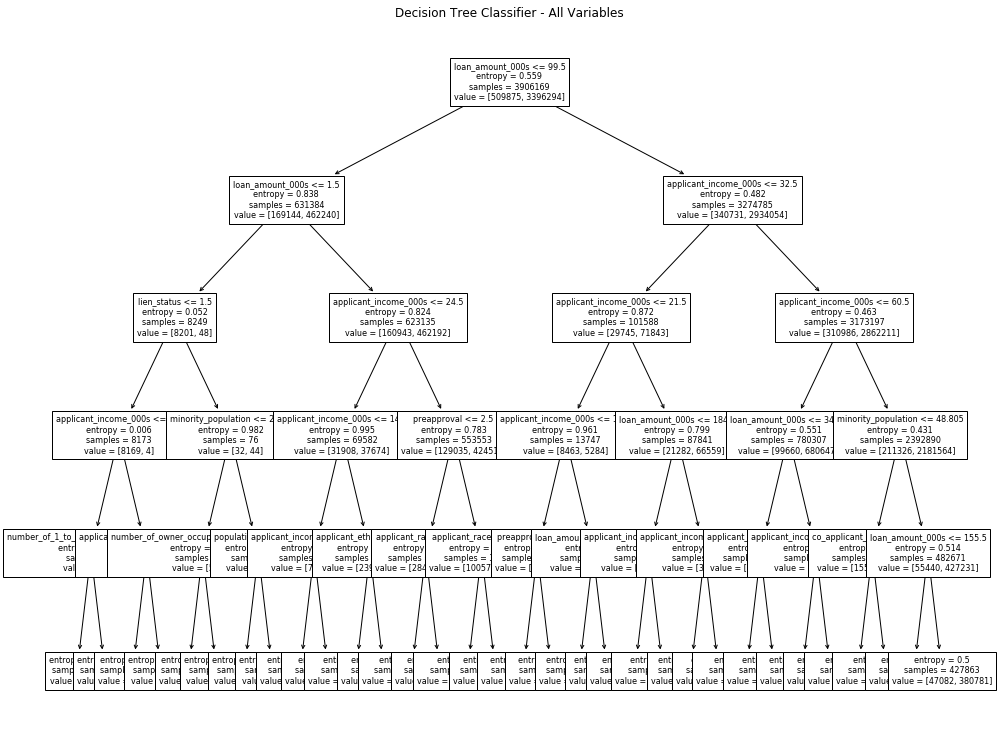

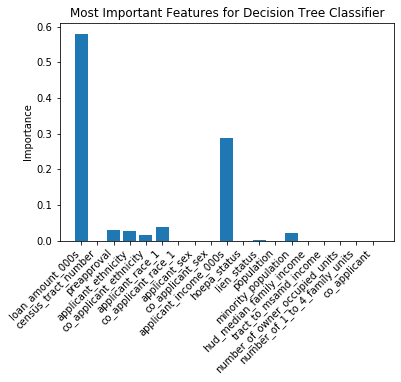

In [126]:
review(grid_dtc, plot_tree_title='Decision Tree Classifier - All Variables',
       plot_importance_title='Most Important Features for Decision Tree Classifier',
       feature_names=x_train.columns.values)

Next we try the same hyperparameters and model, but using only Census indicators:
**something is wrong with this one?**

In [116]:
census_indicators = ['census_tract_number', 'population', 'minority_population',
                    'hud_median_family_income', 'tract_to_msamd_income',
                    'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']
x_train_census  = x_train.loc[:, census_indicators]
x_test_census = x_test.loc[:, census_indicators]

In [132]:
parameters_dtc_C = {'random_state':[0],'max_depth':[3,5],'criterion':['gini']}

grid_dtc_C = GridSearchCV(DecisionTreeClassifier(), parameters_dtc_C,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc_C.fit(x_train_census, y_train)

results_dtc_C = pd.DataFrame.from_dict(grid_dtc_C.cv_results_)
results_dtc_C[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  1.2min remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 3, 'random_...",0.869469,1.0,0.869469
1,"{'criterion': 'gini', 'max_depth': 5, 'random_...",0.869469,1.0,0.869469


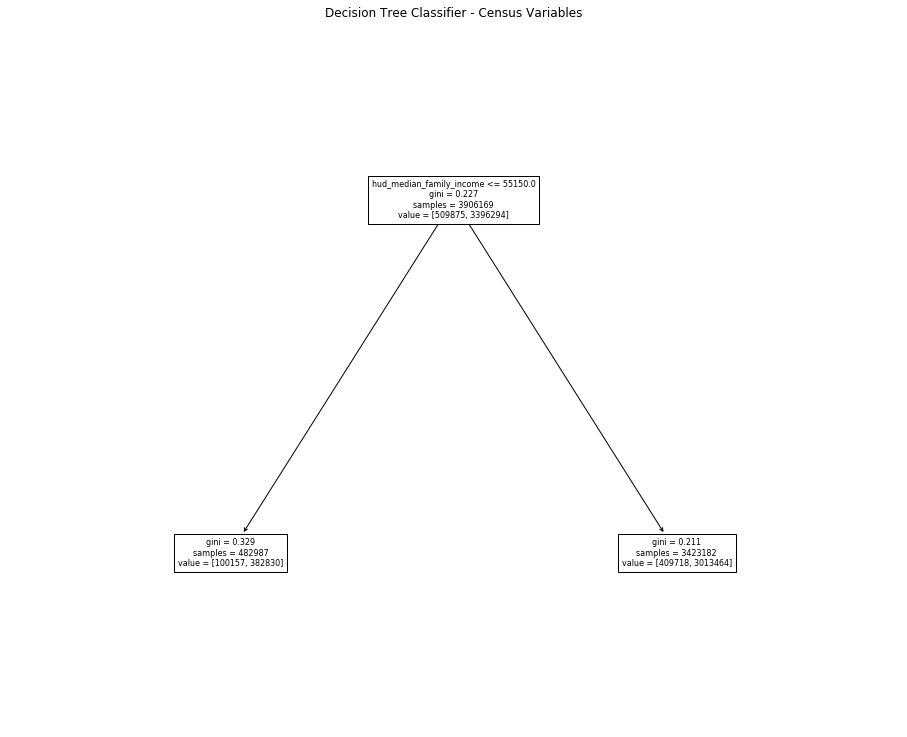

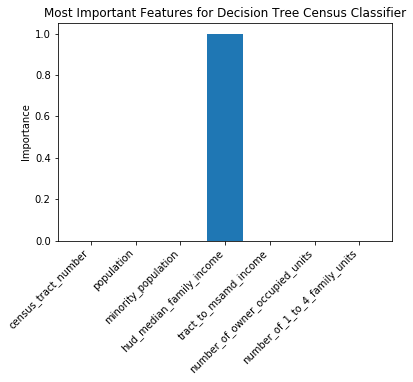

In [127]:
review(grid_dtc_C, plot_tree_title='Decision Tree Classifier - Census Variables',
       plot_importance_title='Most Important Features for Decision Tree Census Classifier',
       feature_names=census_indicators)

Lastly, we again use a Decision Tree Classifier and the same hyperparameters while using the same Census indicators above with the applicant demographic characteristics (race, sex, and ethnicity).
**It's likely that these variables are correlated; should we show a visualization about this?**

In [128]:
census_and_demos_indicators = ['applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
                           'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
                            'census_tract_number', 'population', 'minority_population',
                            'hud_median_family_income', 'tract_to_msamd_income',
                            'number_of_owner_occupied_units', 'number_of_1_to_4_family_units']
x_train_census_traits = x_train.loc[:, census_and_demos_indicators]

In [129]:
parameters_dtc_addl = {'random_state':[0],'max_depth':[1,3,5],'criterion':['gini']}
grid_dtc_addl = GridSearchCV(DecisionTreeClassifier(), parameters_dtc_addl,
                        scoring = ['accuracy', 'recall', 'precision'], cv=10, 
                        refit='accuracy', n_jobs=-1, verbose=2)

grid_dtc_addl.fit(x_train_census_traits, y_train)

results_dtc_addl = pd.DataFrame.from_dict(grid_dtc_addl.cv_results_)
results_dtc_addl[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 1, 'random_...",0.869469,1.000000,0.869469
1,"{'criterion': 'gini', 'max_depth': 3, 'random_...",0.870025,0.999632,0.870190
2,"{'criterion': 'gini', 'max_depth': 5, 'random_...",0.870614,0.997464,0.872108


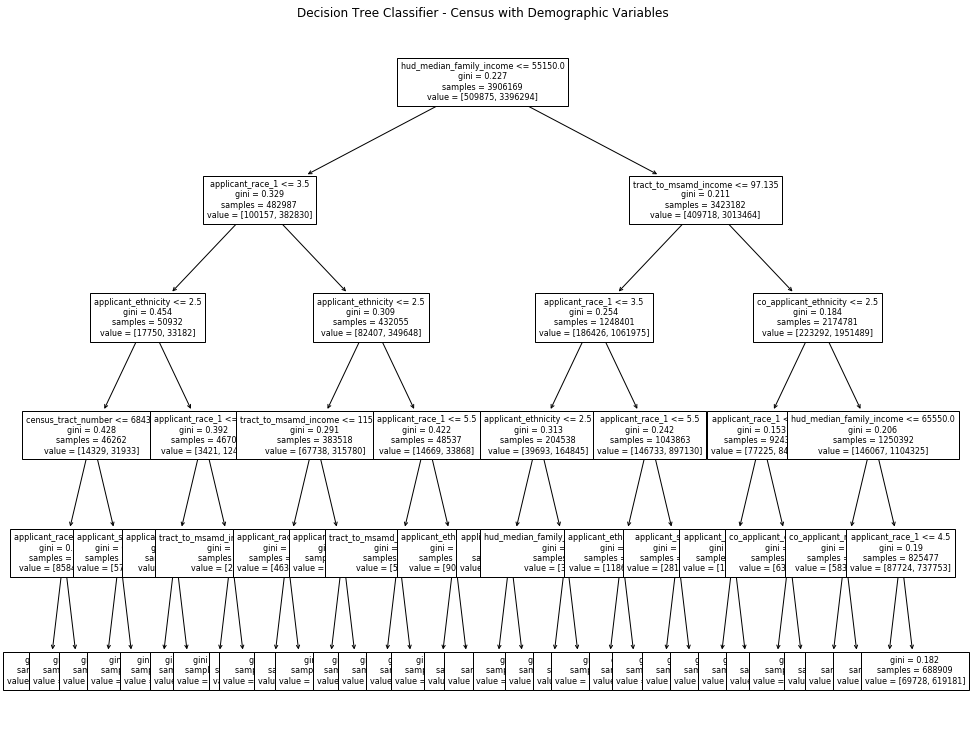

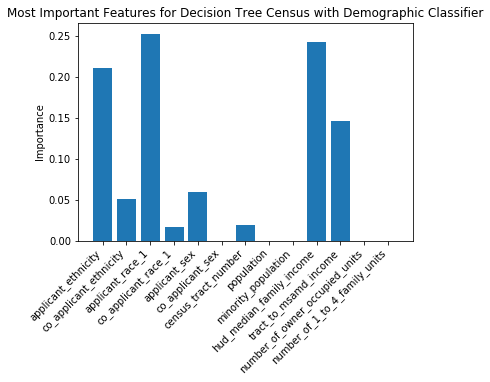

In [131]:
review(grid_dtc_addl, plot_tree_title='Decision Tree Classifier - Census with Demographic Variables',
       plot_importance_title='Most Important Features for Decision Tree Census with Demographic Classifier',
       feature_names=census_and_demos_indicators)

##### Random Forest Classifier

We now try a Random Forest Classifier to improve the accuracy of our estimates. We use a limited set of hyper parameters with a GridSearchCV on a sample of the data, and use the entire available dataset after selecting the most promising of these parameters. We also only use Gini as a measure of impurity to make computation easier.

Ideally, this will limit any overfitting in the model.

In [75]:
x_train_sample = x_train.iloc[:5000,:]
y_train_sample = y_train.iloc[:5000,:]

In [79]:
parameters_sample = {'random_state':[0],
              'n_estimators':[100, 1000, 5000],
              'max_depth':[3, 5, 7],
              'criterion':['gini']}

grid_sample = GridSearchCV(RandomForestClassifier(),
                      parameters_sample,
                      scoring = ['accuracy', 'recall', 'precision'],
                      cv=10, refit='accuracy', n_jobs = -1,verbose=2)

y_train_sample_array = np.array(y_train_sample).reshape(-1)

grid_sample.fit(x_train_sample, y_train_sample_array)

results_sample = pd.DataFrame.from_dict(grid_sample.cv_results_)
results_sample[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.0min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.8698,1.000000,0.869800
1,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.8698,1.000000,0.869800
2,"{'criterion': 'gini', 'max_depth': 3, 'n_estim...",0.8698,1.000000,0.869800
3,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.8700,0.999770,0.870123
4,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.8704,1.000000,0.870323
5,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.8702,1.000000,0.870149
6,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.8712,0.999080,0.871617
7,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.8706,0.998621,0.871390
8,"{'criterion': 'gini', 'max_depth': 7, 'n_estim...",0.8708,0.998851,0.871416


We then try the most promising hyperparameters with the full dataset. Given the training time, we select a max depth of 7 and n_estimators of 100.

In [ ]:
parameters = {'random_state':[0],
              'n_estimators':[100],
              'max_depth':[7],
              'criterion':['gini']}

grid_r = GridSearchCV(RandomForestClassifier(),
                      parameters,
                      scoring = ['accuracy', 'recall', 'precision'],
                      cv=10, refit='accuracy', n_jobs = -1,verbose=2)

y_train_array = np.array(y_train).reshape(-1)

grid_r.fit(x_train, y_train_array)

results_r = pd.DataFrame.from_dict(grid_r.cv_results_)
results_r[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


We also tried max_depth of 5 with 100 n_estimators.

In [72]:
parameters_rf2 = {'random_state':[0],
              'n_estimators':[100],
              'max_depth':[5],
              'criterion':['gini']}

grid_rf2 = GridSearchCV(RandomForestClassifier(),
                      parameters_rf2,
                      scoring = ['accuracy', 'recall', 'precision'],
                      cv=10, refit='accuracy', n_jobs = -1,verbose=2)

y_train_array = np.array(y_train).reshape(-1)

grid_rf2.fit(x_train, y_train_array)

results_rf2 = pd.DataFrame.from_dict(grid_rf2.cv_results_)
results_rf2[['params','mean_test_accuracy','mean_test_recall','mean_test_precision']]

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 29.4min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 47.4min finished


,params,mean_test_accuracy,mean_test_recall,mean_test_precision
0,"{'criterion': 'gini', 'max_depth': 5, 'n_estim...",0.870681,0.999848,0.870622


### Evaluation Metrics

We use comparisons across the resulting confusion matrices from all models, evaluating the ROC curves; as well as accuracy, precision, recall, and F1 scores. We use both a Cross-Validation and Probability Thresholds approach. We also calculate and visualize the feature important for the Decision Tree and Random Forest Classifiers. Lastly, we create crosstabs against race, sex, and ethnicity to determine if our prediction rates meaningfully fluctuate across these characteristics. 

##### Feature Importance

ValueError: shape mismatch: objects cannot be broadcast to a single shape

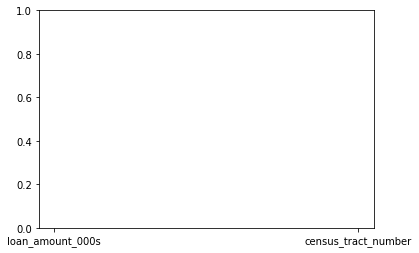

In [85]:
feature_scores_dtc = grid_dtc.best_estimator_.feature_importances_

# Plot
plt.figure()
plt.bar(x_train.columns, feature_scores_dtc)
plt.title('Most Important Features for Decision Tree Classifier')
plt.ylabel('Importance')
plt.xticks(range(20), features, rotation=45, ha='right')
plt.show()

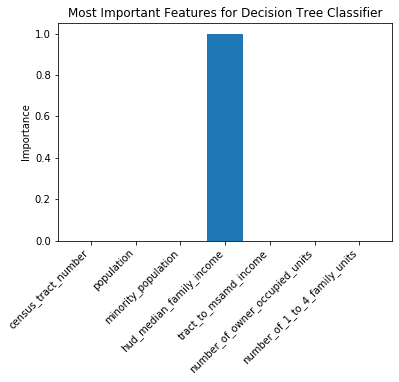

In [90]:
feature_scores_dtc_C = grid_dtc_C.best_estimator_.feature_importances_

# Plot
plt.figure()
plt.bar(census_indicators, feature_scores_dtc_C)
plt.title('Most Important Features for Decision Tree Classifier')
plt.ylabel('Importance')
plt.xticks(range(len(census_indicators)), census_indicators, rotation=45, ha='right')
plt.show()

In [ ]:
fig2, ax2 = plt.subplots(1,1)
plot_precision_recall_curve(grid.best_estimator_, x_test, y_test, ax=ax2)
plot_precision_recall_curve(grid_r.best_estimator_, x_test_r, y_test_r, ax=ax2)

In [ ]:
confusion_matrix(y_test2, grid_r.predict(x_test2))

In [ ]:
print('Precision: ', precision_score(y_test3, grid3.predict(x_test3)))
print('Recall: ', recall_score(y_test3, grid3.predict(x_test3)))
print('F1-Score: ', f1_score(y_test3, grid3.predict(x_test3)))

##### Thresholds Fixed Values - need to update the code

In [ ]:
probabilities = grid_r.best_estimator_.predict_proba(x_test_r)[:,1]
thresholds = [0,.3,.5,.7,.9]
scores = []
for i in thresholds:
    n = [(1 if a > i else 0) for a in probabilities]
    p = precision_score(y_test, n)
    r = recall_score(y_test, n)
    scores.append([i,p,r])
    
fixed_values = pd.DataFrame(scores)
fixed_values.columns = ['threshold', 'precision','recall']
fixed_values.head(6)

##### Thresholds Percentages

In [ ]:
probabilities = pd.DataFrame(grid_r.best_estimator_.predict_proba(x_test_r)[:,1])
probabilities.columns = ['scored']
probabilities['class'] = 0
thresholds = [.01,.05,.1,.2,.5,1]
scores = []

#mark
for i in thresholds:
    max_val = probabilities.shape[0]
    to_return = int((max_val * i))
    index_nums = probabilities.nlargest(to_return, columns = 'scored').index
    for j in index_nums:
        probabilities.iloc[j,1] = 1
    
    p = precision_score(y_test, probabilities['class'])
    r = recall_score(y_test, probabilities['class'])
    scores.append([i,p,r])
    
fixed_values = pd.DataFrame(scores)
fixed_values.columns = ['threshold', 'precision','recall']
fixed_values.head(6)